In [1]:
import numpy as np
import torch

from data import *
from loss import *
from experiment_settings import *

## Create Data

In [2]:
training_loader, testing_loader, Us, ws, task_record = create_datasets_2(totalTasks=T, numClusters=L, perCluster=N_L, numSamples=s, baseDim=d, subDim=k, batchSize=int(s/1), sigma=20)

## Context-Free Prediction

### FTL

In [18]:
def FTL(rewards):
    """
    Input:
    rewards - list of cumulative rewards indexed by experts
    Output:
    action  - task with leading cumulative reward; ties are broken by choosing an expert uniformly at random
    """
    action = np.random.choice(np.flatnonzero(rewards == rewards.max()))
    return action


### MW

In [41]:
def MWA(rewards, eta):
    """
    Input:
    rewards - list of cumulative rewards indexed by experts
    eta     - randomness hyperparameter
    Output:
    action  - sampled task from exponentially weighted distribution
    """
    
    weights = np.exp(eta*rewards)
    action_cat = torch.distributions.Categorical(torch.tensor(weights/sum(weights)))
    action = int(action_cat.sample())
    return action

## Simulation

In [51]:
def context_free_sim(alg,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action = alg(*args)
        reward_cum += (action == task_record[t])
        rewards.append(reward_cum)
        for i in range(L):
            rewards_actual[i] += (task_record[t] == i)
        regrets.append(max(rewards_actual) - reward_cum)
    return regrets
regrets_FTL = context_free_sim(FTL,[task_record])
regrets_MWA = context_free_sim(MWA,[task_record,1]) 

(0.0, 159.55)

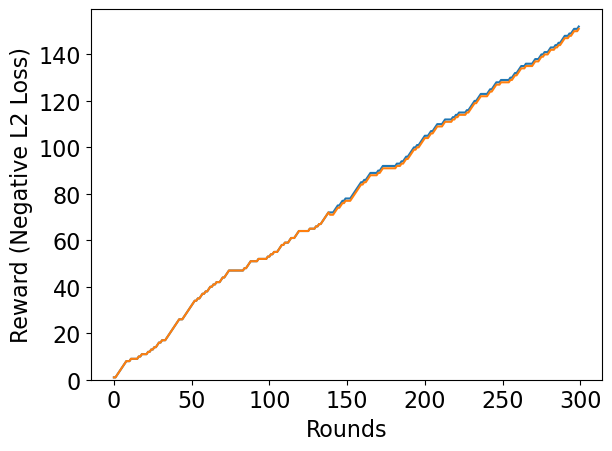

In [52]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})
all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
_style = ['-', '--', '-.', ':', '-','--']

x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(regrets_FTL)
plt.plot(regrets_MWA)

plt.xlabel("Rounds")
plt.ylabel("Reward (Negative L2 Loss)")
plt.ylim(0, y_lim)

### Exp3

In [ ]:
def Exp3(rewards,contexts):
    """
    Code that implements the Exponential weights algorithm for Exploration and Exploitation. 
    Returns index of largest reward.
    """

## Context-Dependent Algorithms

### Exp4

In [ ]:
def Exp4(rewards,contexts):
    """
    Code that implements the Exponential weights algorithm for Exploration and Exploitation with Experts. 
    Returns index of largest reward.
    """